# Лабораторная работа №4, Фундаментальные концепции ИИ
## Восстановление функции распределения вероятности
### Алапанова Эльза, М8О-109СВ-24


Импортируем необходимые библиотеки

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, norm
from sklearn.mixture import GaussianMixture


## Метод ядерного сглаживания

In [2]:
def kernel_density_estimation(data, bandwidth):
    """
    Выполняет оценку плотности методом KDE (ядровая оценка плотности).
    :param data: Массив данных для оценки.
    :param bandwidth: Ширина ядра (параметр сглаживания).
    :return: Объект gaussian_kde.
    """
    kde = gaussian_kde(data, bw_method=bandwidth) # Создаем объект KDE с заданной шириной ядра.
    return kde


## EM алгоритм

In [3]:
def em_density_estimation(data, n_components=2):
    """
    Выполняет оценку плотности методом EM (алгоритм ожидания-максимизации) с использованием Gaussian Mixture Model.
    :param data: Массив данных для оценки.
    :param n_components: Число компонент в смеси Гауссовых распределений.
    :return: Обученный объект GaussianMixture.
    """
    data = data.reshape(-1, 1)  # Преобразуем данные в двумерный массив (требование для GMM).
    gmm = GaussianMixture(n_components=n_components, random_state=0)  # Создаем модель GMM.
    gmm.fit(data)  # Обучаем модель на данных.
    return gmm


## Тестирование метода ядерного сглаживания

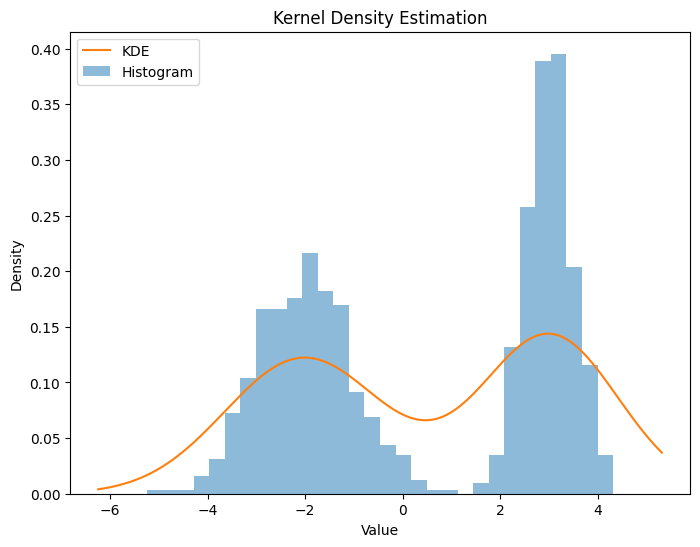

In [4]:
# Генерация данных из двух нормальных распределений
np.random.seed(42)
data = np.concatenate([
    np.random.normal(-2, 1, 500), # Первое распределение: среднее -2, стандартное отклонение 1
    np.random.normal(3, 0.5, 500) # Второе распределение: среднее 3, стандартное отклонение 0.5
])

kde = kernel_density_estimation(data, bandwidth=0.5)  # Создаем оценку KDE с шириной ядра 0.5.
x = np.linspace(data.min() - 1, data.max() + 1, 1000)  # Создаем точки для визуализации.

y_kde = kde(x)  # Вычисляем значения плотности для каждого x.

# Визуализация результата KDE

plt.figure(figsize=(8, 6))
plt.hist(data, bins=30, density=True, alpha=0.5, label='Histogram')
plt.plot(x, y_kde, label='KDE')
plt.title('Kernel Density Estimation')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()


## Тестирование EM алгоритма

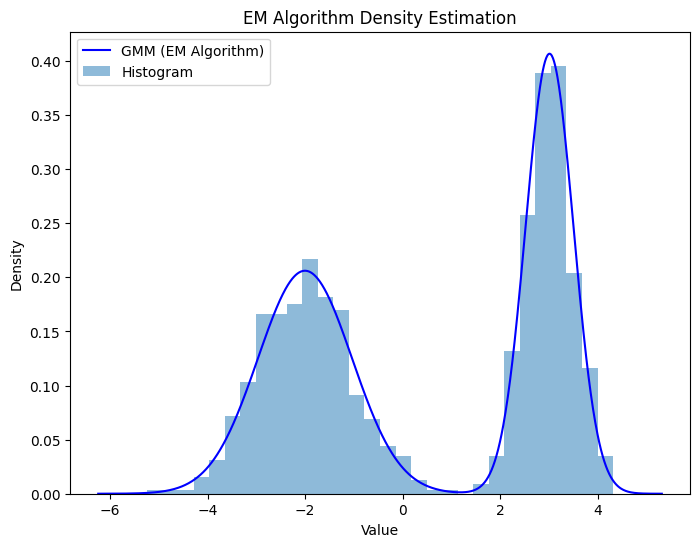

In [5]:
np.random.seed(42)
data = np.concatenate([
    np.random.normal(-2, 1, 500),
    np.random.normal(3, 0.5, 500)
])

gmm = em_density_estimation(data, n_components=2) # Создаем GMM с двумя компонентами

x = np.linspace(*(data.min() - 1, data.max() + 1), 1000).reshape(-1, 1) # Преобразуем x в двумерный массив

log_density = gmm.score_samples(x) # Вычисляем логарифм плотности для каждого x
y_gmm = np.exp(log_density) # Преобразуем логарифм плотности в плотность

# Визуализация результата EM
plt.figure(figsize=(8, 6))
plt.hist(data, bins=30, density=True, alpha=0.5, label='Histogram')
plt.plot(x, y_gmm, label='GMM (EM Algorithm)', color='blue')
plt.title('EM Algorithm Density Estimation')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()


## Метод Метрополиса-Гастинга

In [6]:
def metropolis_hastings(target_density, initial_value, n_samples, proposal_std):
    """
    Реализация алгоритма Метрополиса-Гастингса для выборки из заданного распределения.
    :param target_density: Целевая плотность распределения.
    :param initial_value: Начальное значение для цепи.
    :param n_samples: Число выборок.
    :param proposal_std: Стандартное отклонение для предложения нового значения.
    :return: Массив выборок.
    """
    samples = [initial_value]
    current = initial_value
    for _ in range(n_samples - 1):
        proposal = np.random.normal(current, proposal_std) # Генерация нового значения на основе нормального распределения
        acceptance_ratio = target_density(proposal) / target_density(current) # Вычисляем отношение вероятностей
        if np.random.rand() < acceptance_ratio: # Принимаем или отклоняем новое значение
            current = proposal
        samples.append(current)
    return np.array(samples)


## Метод Гиббса

In [7]:
def gibbs_sampling(initial_values, conditional_distributions, n_samples):
    """
    Реализация алгоритма Гиббса для выборки из многомерного распределения.
    :param initial_values: Начальные значения переменных.
    :param conditional_distributions: Условные распределения для каждой переменной.
    :param n_samples: Число выборок.
    :return: Массив выборок.
    """
    samples = [initial_values]
    current = np.array(initial_values)
    for _ in range(n_samples - 1):
        for i, conditional in enumerate(conditional_distributions):
            current[i] = conditional(*current[:i], *current[i + 1:])
        samples.append(current.copy())
    return np.array(samples)


## Метод ядерного сглаживания + Метод Метрополиса-Гастинга + Метод Гиббса

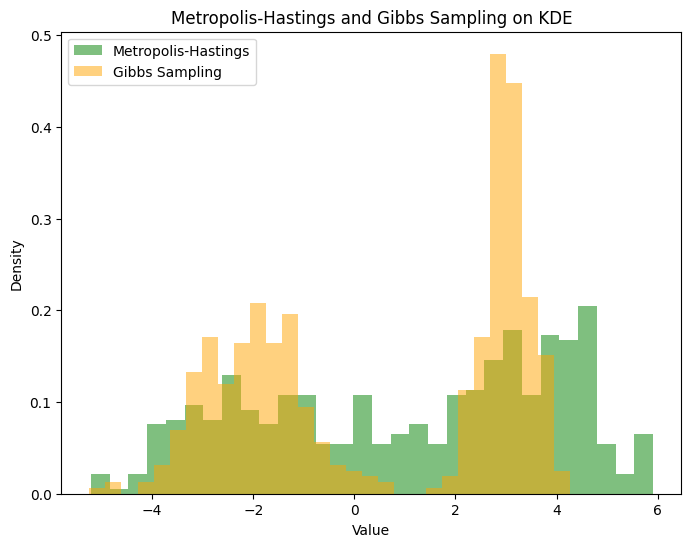

In [8]:
np.random.seed(42)
data = np.concatenate([
    np.random.normal(-2, 1, 500),
    np.random.normal(3, 0.5, 500)
])

kde = kernel_density_estimation(data, bandwidth=0.5) # Используем KDE как целевую плотность
n_samples = 500

target_density = kde.evaluate
mh_samples = metropolis_hastings(target_density, data.mean(), n_samples, proposal_std=1.0) # Метрополис-Гастингс

gibbs_samples = gibbs_sampling(
    [data.mean()], 
    [lambda: np.random.choice(data)], 
    n_samples
) # Гиббс

# Визуализация выборок Метрополис-Гастингса и Гиббса
plt.figure(figsize=(8, 6))
plt.hist(mh_samples, bins=30, density=True, alpha=0.5, label='Metropolis-Hastings', color='green')
plt.hist(gibbs_samples, bins=30, density=True, alpha=0.5, label='Gibbs Sampling', color='orange')
plt.title('Metropolis-Hastings and Gibbs Sampling on KDE')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()


1. Качество аппроксимации:

- Распределение, полученное методом Metropolis-Hastings, лучше отражает форму исходной выборки с использованием KDE. Оно детализирует пики и распределение плотности значений.
- Gibbs Sampling имеет тенденцию создавать более узкие пики вблизи определенных значений. Это может быть связано с особенностями сэмплирования из условных распределений.

2. Шум и точность:

- Метод Metropolis-Hastings демонстрирует некоторую вариативность в низких плотностях (например, около -4 и 4), что может быть вызвано случайным характером его выборок.
- Метод Gibbs Sampling, напротив, показывает более сглаженную плотность, но это может быть за счет некоторого упрощения структуры.

3. Применение KDE как целевой функции:

- Оба метода в целом неплохо приближают исходное распределение, но Metropolis-Hastings лучше справляется с мультигорбым характером данных.

## EM-алгоритм + Метод Метрополиса-Гастинга + Метод Гиббса

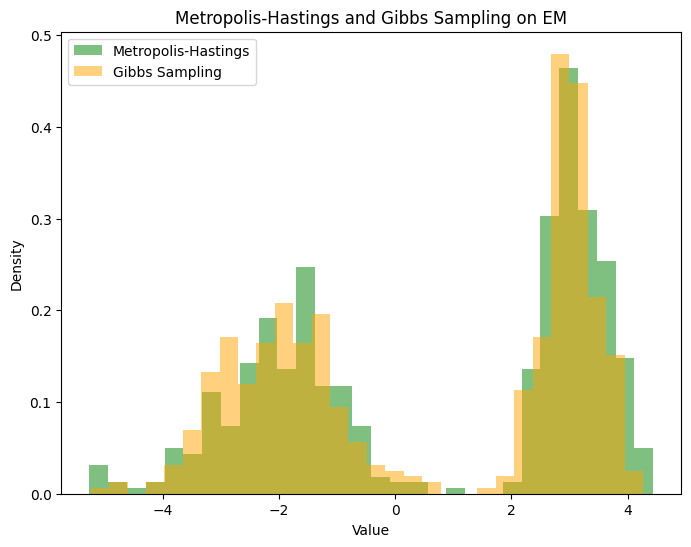

In [9]:
np.random.seed(42)
data = np.concatenate([
    np.random.normal(-2, 1, 500),
    np.random.normal(3, 0.5, 500)
])

gmm = em_density_estimation(data, n_components=2)

def target_density(x):
    return np.exp(gmm.score_samples(np.array([[x]])))

mh_samples = metropolis_hastings(target_density, data.mean(), n_samples, proposal_std=1.0)

gibbs_samples = gibbs_sampling(
    [data.mean()], 
    [lambda: np.random.choice(data)], 
    n_samples
)

# Визуализация выборок Метрополис-Гастингса и Гиббса на EM
plt.figure(figsize=(8, 6))
plt.hist(mh_samples, bins=30, density=True, alpha=0.5, label='Metropolis-Hastings', color='green')
plt.hist(gibbs_samples, bins=30, density=True, alpha=0.5, label='Gibbs Sampling', color='orange')
plt.title('Metropolis-Hastings and Gibbs Sampling on EM')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()


1. Качество аппроксимации:

- Оба метода (Metropolis-Hastings и Gibbs Sampling) хорошо отражают распределение, основанное на смеси двух гауссианов (EM). Плотности данных двух групп явно видны.

2. Разделение кластеров:

- Оба алгоритма правильно распознают разделение данных на два гауссиана (с центрами примерно в -2 и 3). Распределение между кластерами также учитывается.

3. Сравнение методов:

- Gibbs Sampling снова кажется более склонным к созданию резких пиков, тогда как Metropolis-Hastings создает чуть более плавное распределение.
- Для этой задачи оба метода дают очень близкие результаты, так как плотность EM проще для аппроксимации.


## Выводы

1. Metropolis-Hastings:

- Лучше подходит для сложных распределений с мультигорбым характером (например, KDE).
- Требует более точной настройки параметров (например, дисперсии предложения), чтобы избежать шума.

2. Gibbs Sampling:

- Упрощает аппроксимацию распределений, но может быть менее точным в задачах с комплексной структурой.
- Работает особенно эффективно, если известны условные распределения.

3. Общее качество:

- Для обеих задач (KDE и EM) оба метода показывают разумные результаты.
- Выбор метода зависит от конкретной задачи: сложные распределения лучше аппроксимировать Metropolis-Hastings, а более простые — Gibbs Sampling.